In [5]:
import torch

from torchvision import transforms, datasets
import os

from util import showtensor
from resnet import resnet50
from deepdream import dream



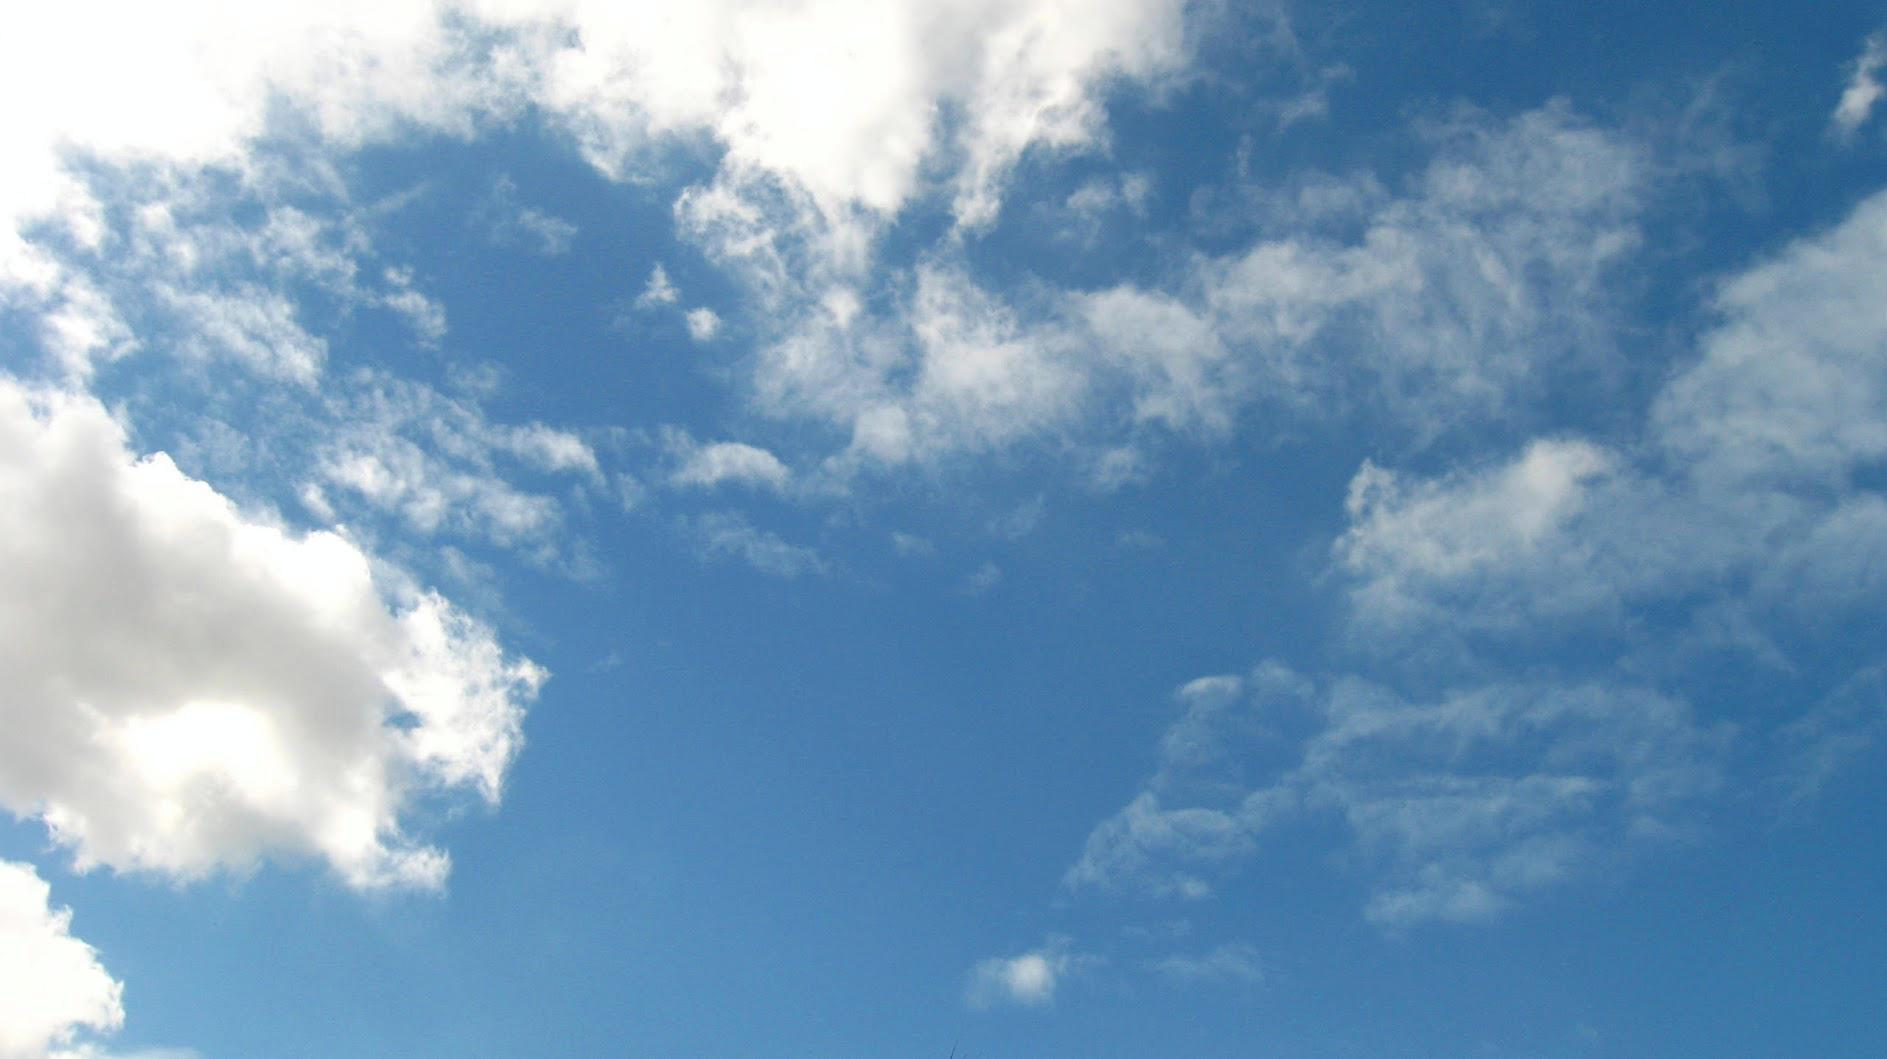

In [6]:
# load the data
transforms = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
dset = datasets.ImageFolder(os.path.join('./data/'), transforms)
dset_loader = torch.utils.data.DataLoader(dset, batch_size=1)
inputs, classes = next(iter(dset_loader))
input_np = inputs.numpy()
showtensor(input_np)

In [7]:
# load the model
model = resnet50(pretrained=True)
model.cuda()
for param in model.parameters():
    param.require_grads = False

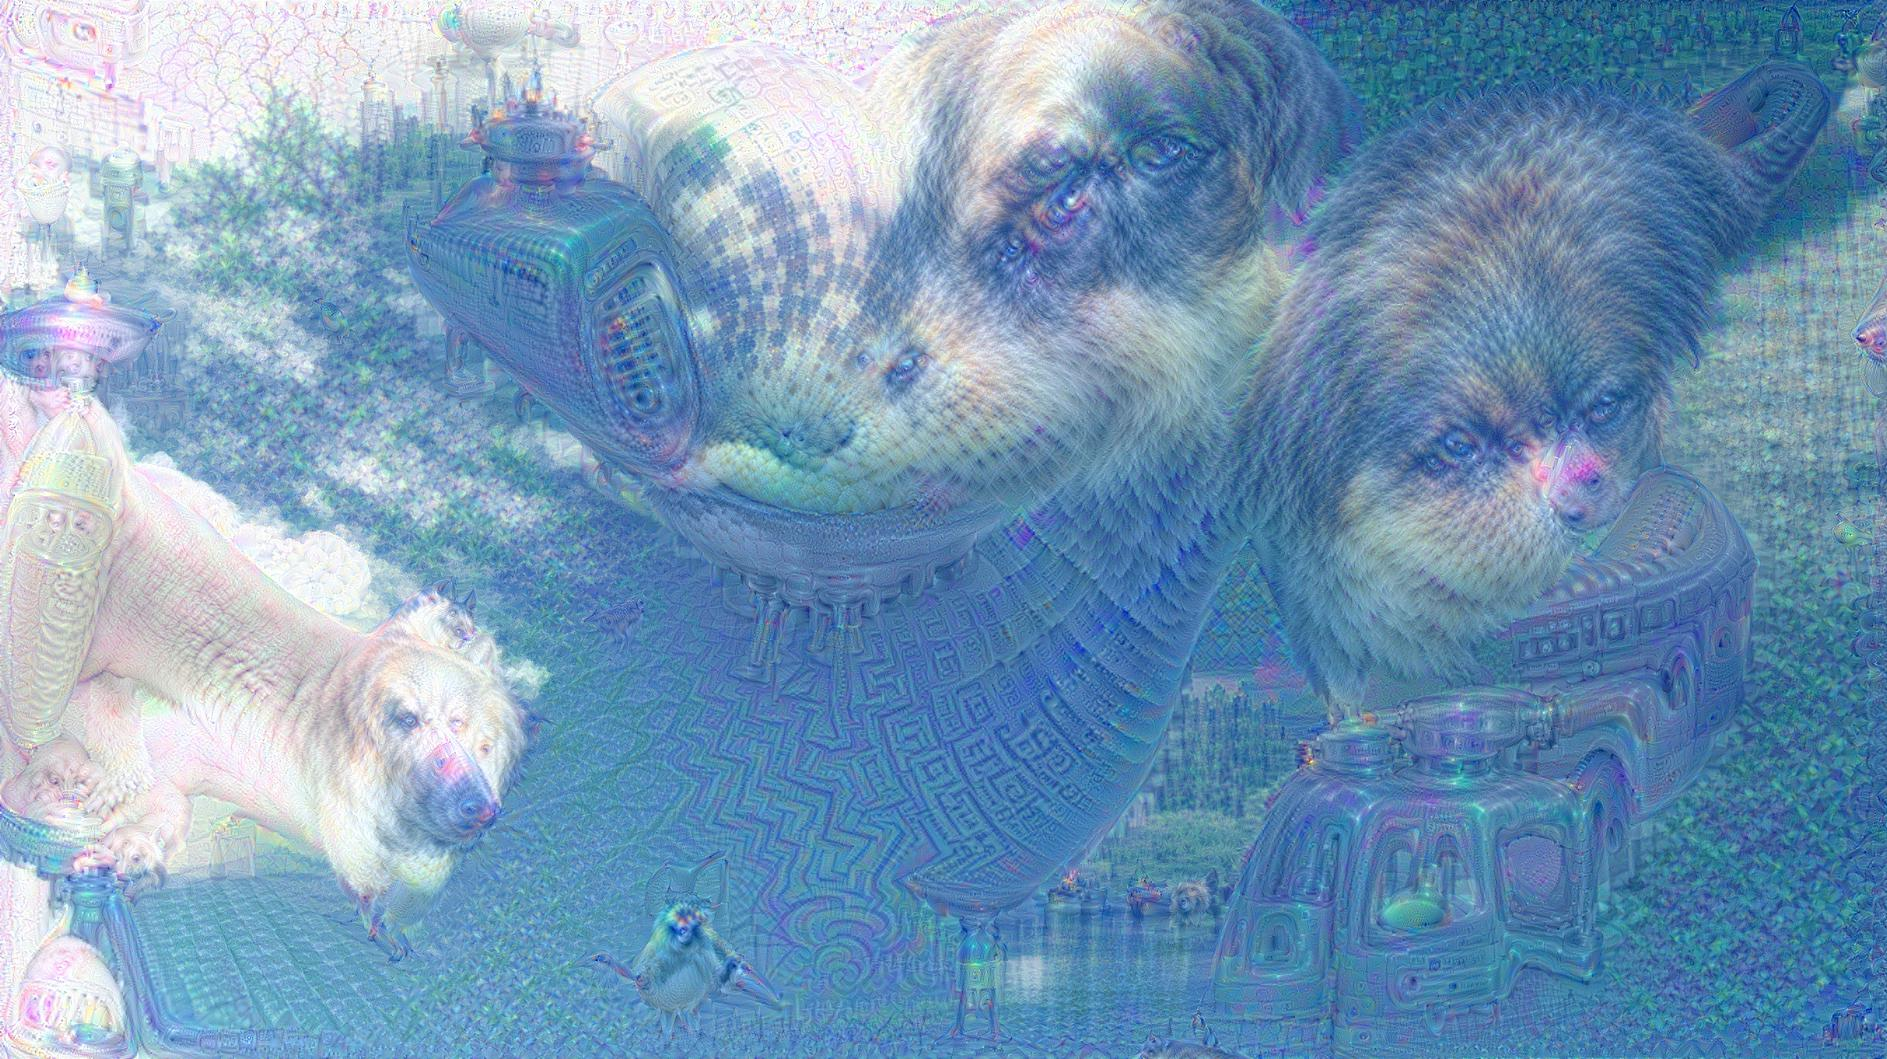

In [8]:
# deep dream
dream(model, input_np, 
          octave_n=6, 
          num_iterations=20, 
          lr=2e-2,
          max_jitter=32,
          show_every=10,
          end_layer=3)

# control the dream

In [9]:
from torch.autograd import Variable
from torchvision import transforms, datasets
import os
import torch
from resnet import resnet50
from deepdream import dream
import numpy as np

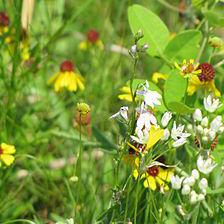

In [10]:
# get guide feature
transforms = transforms.Compose([
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
dset = datasets.ImageFolder(os.path.join('./guide_data/'), transforms)
dset_loader = torch.utils.data.DataLoader(dset, batch_size=1)
inputs_guide, classes_guide = next(iter(dset_loader))
inputs_guide_np = inputs_guide.numpy()
showtensor(inputs_guide_np)

model = resnet50(pretrained=True)
model.cuda()
for param in model.parameters():
    param.require_grads = False

X_Variable = Variable(inputs_guide.cuda())
guide_features = model.forward(X_Variable, n_layer=3)

In [11]:
def objective_guide(dst, guide_features):
#     print(1)
    x = dst.data[0].cpu().numpy().copy()
#     print(type(dst), dst.size(), dst)
#     print(type(guide_features))
    y = guide_features.data[0].cpu().numpy()
#     print(dst.size())
    ch, w, h = x.shape
    x = x.reshape(ch,-1)      # (c，w*h)
    y = y.reshape(ch,-1)      # (c, w*h)
    A = x.T.dot(y) # compute the matrix of dot-products with guide features
    result = y[:,A.argmax(1)] # select ones that match best
    result = torch.Tensor(np.array([result.reshape(ch, w, h)], dtype=np.float)).cuda()
#     print(type(result), result.size(), result)
    return result


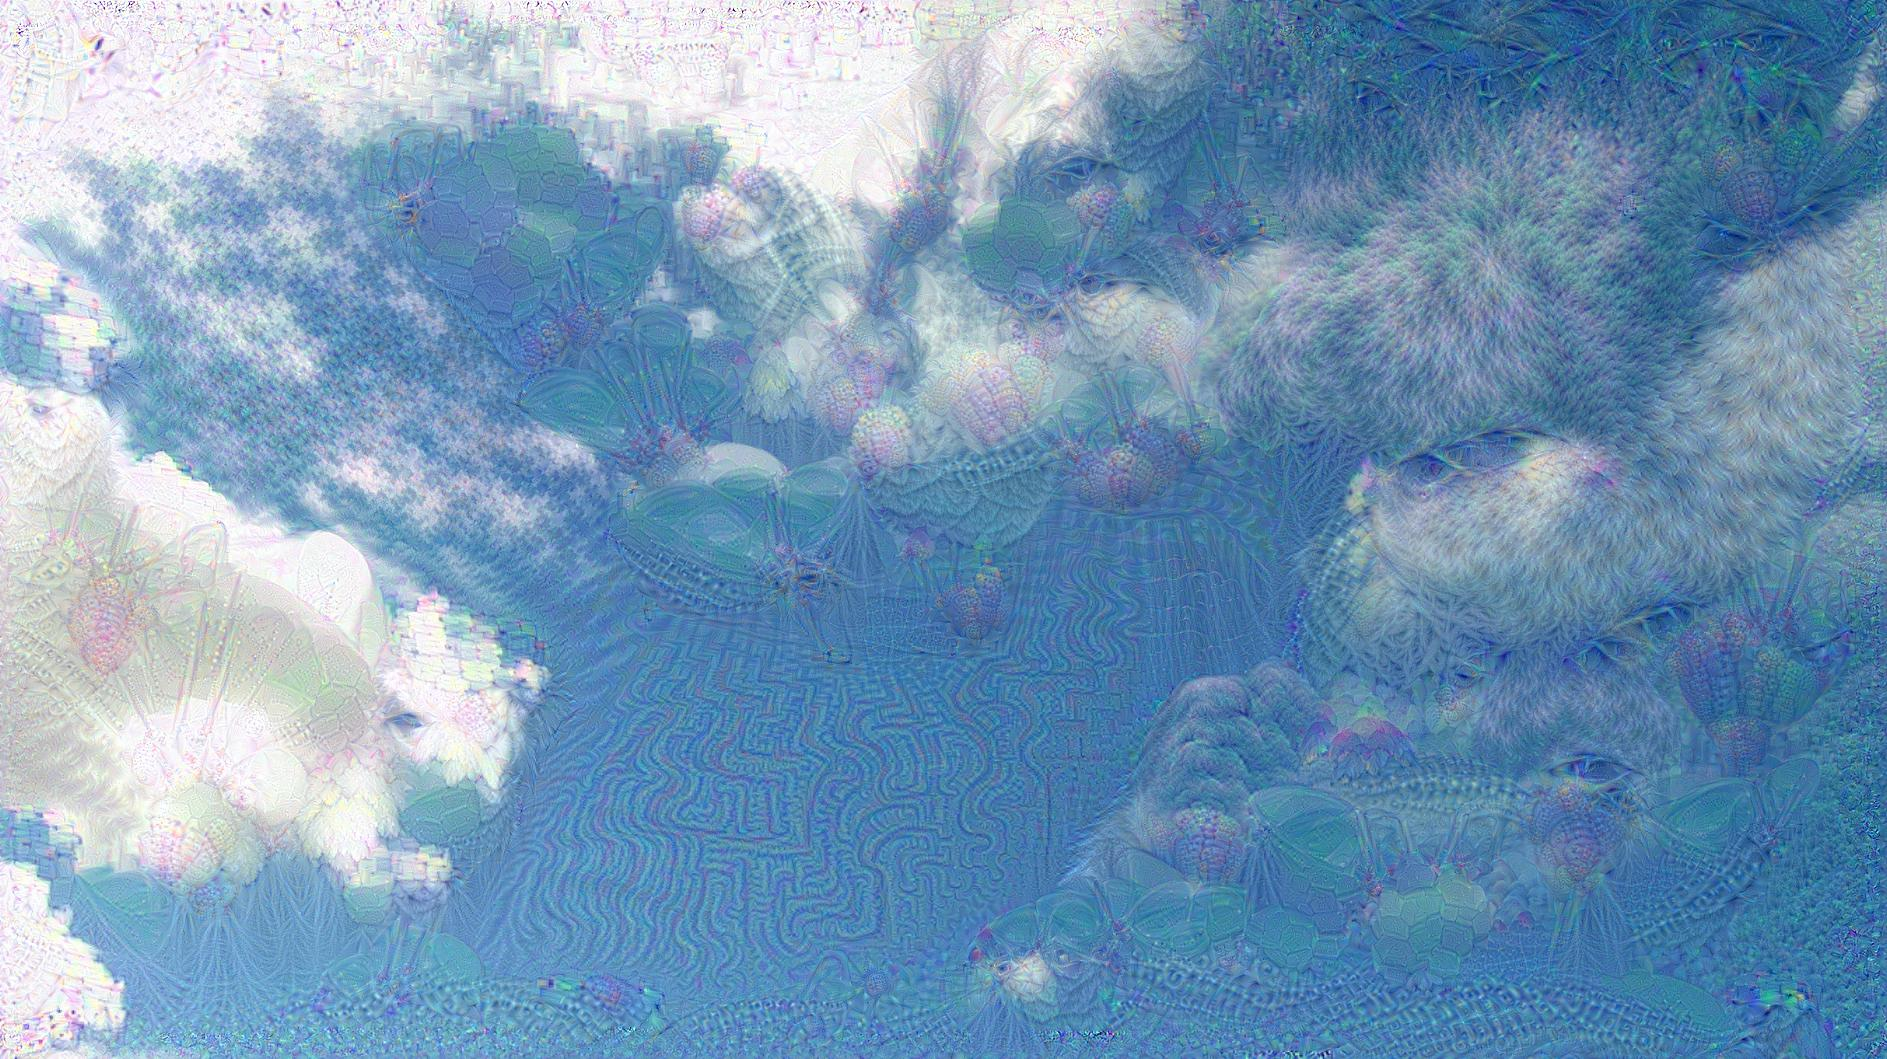

In [12]:
dream(model, input_np, 
          octave_n=4, 
          num_iterations=20, 
          lr=2e-2,
          max_jitter=32,
          show_every=20,
          end_layer=3,
          objective=objective_guide,
          guide_features=guide_features)